# Nansen Legacy stations - ice covered days

**Adam Steer**

**March 2022**

In the Nansey Legacy project, 42 locations were picked for repeat sampling of ocean and other parameters. Some of these sites were in open water for most of the year, some were ice covered between November and June each year. This notebook uses MASIE sea ice extent and Norwegian Ice Service classifications to derive some statistics about how often, and when, each station was covered by ice.

### Analytical method

The intended analytical technique is a polygon-in-polygon method implemented in Shapely [https://shapely.readthedocs.io/en/stable/manual.html]. Station points are buffered by 10km because sampling on Nansen Legacy voyages did not always occur exactly on the planned point.

Points are designated as ice covered if the whole buffer is ice covered.

### Work in progress

- add real station locations from ship logs, rather than planning documents
- add a method for visualising when a station was occupied
- add sea ice concentration estimates

### Datasets

Nansen legacy station locations: https://github.com/SIOS-Svalbard/AeN_data


#### Sea ice extent
MASIE sea ice extent:https://nsidc.org/data/masie
https://nsidc.org/data/user-resources/help-center/how-access-data-using-ftp-client-command-line-wget-or-python

To get a year of shapefiles at once

`wget --ftp-user=anonymous -r -nd ftp://sidads.colorado.edu/DATASETS/NOAA/G02186/shapefiles/1km/2021`

Each shapefile must then be unzipped: `unzip '*.zip'`


#### Sea ice concentration
University of Bremen sea ice concentration: https://seaice.uni-bremen.de/sea-ice-concentration/modis-amsr2/

`wget `

### Setting up

Importing all the python libraries we need here.

### Reproducing this environment

This notebook is built and run in a conda virtual environment. The environment can be built as follows:

`conda create -n env_name -c conda-forge matplotlib numpy scipy pylab pyproj shapely ogr pandas cartopy geojson rioxarray`

There is no need to hardcode package versions - this notebook tries to avoid analytical methods which might be version-breakable.

In [1]:
## import all the libraries

# standard library stuff

import datetime
import json
import glob
import os

# matplotlib stuff

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import pylab as pl
import numpy as np

# a cell magick to show plots in the notebook
%matplotlib inline

# things we need from Pyproj. Review once we're closer to final
from pyproj import CRS
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info
from pyproj import transformer as transformer

# shapely. Review this list at the end, we may not need all of this

from shapely.geometry import Point, LineString, Polygon, shape, GeometryCollection, mapping
import shapely.wkt
from shapely.ops import transform

#OGR, for shapefile reading.
from osgeo import ogr

#Pandas for doing data table manipulation, also for easy IO
import pandas as pd

#geojson

import geojson

#xarray parts for netcdf wrangling

#maybe rasterio is most convenient..
import xarray,rioxarray

In [2]:

# map building with Cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat

import cartopy.feature as cfeature
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])


import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

### Setting up Nansen Legacy stations

These are stored in a GeoJSON file as a latitude, longitude and station label. The GeoJSON file is imported and converted to a shapely geometry. Every NLEG and P station is included in the GeoJSON file. The GeoJSON file should be kept in the same repository as this notebook. 

**To do:** replace this list with extracts from voyage logs to show actual ship positions on each day of each year

In [3]:
# import the file into a JSON dictionary

with open("../mapdata/NansenLegacyStations-sorted.geojson") as f:
    nleg_stations = json.load(f)["features"]

In [4]:
# show what each feature looks like
nleg_stations

[{'type': 'Feature',
  'properties': {'stationName': 'P1 (NLEG01)',
   'decimalLatitude': 76.0,
   'decimalLongitude': 31.22},
  'geometry': {'type': 'Point', 'coordinates': [31.22, 76.0]}},
 {'type': 'Feature',
  'properties': {'stationName': 'NLEG02',
   'decimalLatitude': 76.5,
   'decimalLongitude': 31.22},
  'geometry': {'type': 'Point', 'coordinates': [31.22, 76.5]}},
 {'type': 'Feature',
  'properties': {'stationName': 'NLEG03',
   'decimalLatitude': 77.0,
   'decimalLongitude': 34.0},
  'geometry': {'type': 'Point', 'coordinates': [34.0, 77.0]}},
 {'type': 'Feature',
  'properties': {'stationName': 'P2 (NLEG04)',
   'decimalLatitude': 77.5,
   'decimalLongitude': 34.0},
  'geometry': {'type': 'Point', 'coordinates': [34.0, 77.5]}},
 {'type': 'Feature',
  'properties': {'stationName': 'NLEG05',
   'decimalLatitude': 78.0,
   'decimalLongitude': 34.0},
  'geometry': {'type': 'Point', 'coordinates': [34.0, 78.0]}},
 {'type': 'Feature',
  'properties': {'stationName': 'NLEG06',
   

In [5]:
len(nleg_stations)

42

In [6]:
station_index = [station["properties"]["stationName"] for station in nleg_stations]

### Ice station dates and locations from ship logs

Hard(er) stuff.

What we want in the end is:
- for each year, a set of days when the ship was at a station
- for each station and day, a logged ship position for sampling sea ice presence and concentration

This makes sure that statistics about ice cover are always computed for the correct sampling location.

We need to:
- convert station dates to DOY
- set up an array where for each station name, we get a 1 or 0 for any DOY it was occupied
- this array needs to have the same shape as the ice cover 
- set up another list of station position on a given day, for spatial queries

In [ ]:
#read the Q2 activity log into a dataframe
q2_2021_dates = pd.read_csv("../mapdata/Activity_Log_Q2_2021704_FINAL.csv",
                      skiprows=2)

In [ ]:
q2_2021_dates[0:5]

In [ ]:
#make a 1-366 series
yeardays = np.arange(1, 367, 1)

In [ ]:
# get event days from the q2 dataframe
thedays = q2_2021_dates["eventDate"]

In [ ]:
# see how many times we had events
len(thedays)

each event has a start and end date, a start and end position.

We need:
- for each day of year on which and event happened, a median station position
- a buffer around each of those positions

To do that:
- get event name
- get event start date and convert to DoY
- get event end date and convert to DoY
- get event start position and transform to North Polar Stereo
- get event end position and transform to North Polar Stereo
- assign the mean position for the whole event to the event position for grid plotting. 
- for plotting 'ship on station' days, add a 'ship present' flag for every day of the event

In [ ]:
#create a new dataframe to hold ship present/absent days
q2_2021 = pd.DataFrame(columns = list(yeardays))

In [ ]:
q2_2021.insert(0, "stationName", station_index )

In [ ]:
q2_2021[0:10]

In [ ]:
station_names = q2_2021_dates["stationName"]

In [ ]:
len(station_names)

In [ ]:
days_of_year = []
# we need to end up here with a list of occupied year days for each station,
# eg nleg24: 0-366

for thisday in q2_2021_dates["eventDate"]:

    ### convert the date into a day of year
    #print(thisday)
    theday = datetime.datetime.strptime(thisday, "%d/%m/%y")
    period = pd.Period(theday, freq='D')
    days_of_year.append(period.day_of_year)


In [ ]:
the_station_days = pd.DataFrame({"station_name": q2_2021_dates["stationName"],
                               "day_of_year": days_of_year})

In [ ]:
the_station_days.loc[the_station_days["station_name"] == "P1"]

In [ ]:
q2_2021.loc[q2_2021["stationName"].str.contains("P1 ")][350].values

In [ ]:
that = q2_2021.loc[q2_2021["stationName"].str.contains("P1 ")][350]

In [ ]:
presence = []
for stationday in the_station_days.loc[the_station_days["station_name"] == "P1"].values:
    for theday in yeardays:
        if stationday[1] == theday:
            print(theday)
            this = q2_2021.loc[q2_2021["stationName"].str.contains("P1 ")][theday]
            print(this)
            
            this = 1
        else:
            this = q2_2021.loc[q2_2021["stationName"].str.contains("")][theday]
            this = 0
 
            #presence.append(0)
    

In [ ]:
q2_2021[0:5]

### caution, broken parts exposed here!

In [ ]:
q2_2021["station"] = q2_2021_dates["stationName"].values
q2_2021["yearday"] = days_of_year
q2_2021["presence"] = np.ones(len(days_of_year))

In [ ]:
q2_2021.dropna(inplace = True)
q2_21_2 = q2_2021.pivot(columns = "yearday", index="station", values = "presence")
q2_21_2 = q2_21_2.reindex(stationIndex)

In [ ]:
station21, yearday21 = np.mgrid[:q2_21_2.shape[0]+1, :q2_21_2.shape[1]+1]

fig, ax = plt.subplots(figsize=(30, 10))
#ax.set_aspect("equal")
plt.pcolormesh(yearday21, station21, q2_21_2.values, cmap="Reds", edgecolor="w", vmin=0, vmax=1)
plt.xlim(0, q2_21_2.shape[1])
#plt.yticks(tw17_2["station"])
ax.set_yticks(range(len(q2_21_2.index)))
ax.set_yticklabels(q2_21_2.index, va='bottom')


### Reprojecting and buffering points

Having a set of longitudes and latitudes is less great for analytical work, and working in metres or kilometers is a bit better. So we first want to reproject the coordinates to a system expressed in meters, and then applu a buffer to each point in meters. This is done using the Python API to Proj6 [https://proj.org]

Because MAISIE data already come in (NSIDC North Polar Stereographic)[https://spatialreference.org/ref/epsg/3413/], which is expressed in meters, the Nansen Legacy station points will be reprojected to match. Just one point will be reprojected here to test a method, which will be applied on the fly to all points later - there is no need to build another set of reprojected points. The same applies to buffering.

If we work in premade buffered geometry sets, we lose track of metadata - station IDs. So, when we do the iteration over all stations and ice extent datasets later, we will do reprojection and buffering as we go. Don't worry, it is fast!

Rather than write out projections strings in full, we use EPSG short codes to tell Proj what to do. For reference, here they are in full:

NSIDC North Polar Stereographic: `+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs `

WGS84 lat / lon: `+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs `

### to do

- reconfigure this process to use different sets of positions for each year instead of using a list of fixed locations

In [7]:
#set up a transformer
nleg_transformer = transformer.Transformer.from_crs(4326,
                                                "+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

In [8]:
#get our feature of interest and transform it. P7 is a nice one to play with..
# found by iterating manually through the dictionary...

nleg_stations[24]["properties"]["stationName"]

'P7/ NLEG25'

In [9]:
nleg_stations[24]["geometry"]

{'type': 'Point', 'coordinates': [30.8846, 81.8027]}

In [10]:
#transform! OK, we can probably stop at two decimal points in the result, and would
# if we had a billion coordinates - but it isn't really necessary here.
p7northpolar = nleg_transformer.transform(nleg_stations[24]["geometry"]["coordinates"][1],
                                      nleg_stations[24]["geometry"]["coordinates"][0])
p7northpolar

(862592.5516443305, -216914.76587085257)

In [11]:
#make a point geometry
p7point = Point(p7northpolar[0], p7northpolar[1])
print(mapping(p7point))

{'type': 'Point', 'coordinates': (862592.5516443305, -216914.76587085257)}


In [12]:
#buffer the point in meters
p7dot = p7point.buffer(5000)

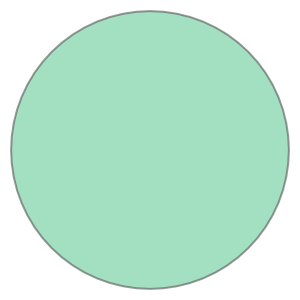

In [13]:
p7dot

In [ ]:
# to see the dot geometry as GeoJSON, uncomment the next line and run this cell
#print(mapping(p7dot))

### Loading MASIE ice extent data, testing the method

MASIE ice extent data are provided as ESRI shapefiles, which can be loaded into shapely geometries. The first step is to load and inspect two shapefiles - one where we know there was ice cover, and one where there was not - then test the method for ice coverage determination. This will form a foundation for the next step - iterating over all the MAISIE files and Nansen Legacy stations to produce the final dataset!

Only the two test shapefiles are included in this repository - please download your own MAISIE data here: https://nsidc.org/data/masie


In [ ]:
# set up a holder for dates and results - each row should contain a station ID,
# a date, and a true/false result
icy_days = pd.DataFrame(columns=["date", "station_name", "ice_cover"])

In [ ]:
maisienorthpolar = "+proj=stere +lat_0=90 +lat_ts=60 +lon_0=-80 +k=1 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs"
epsg3413northpolar = "+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs"

In [ ]:
maisie_transform = transformer.Transformer.from_proj(maisienorthpolar,
                                                        epsg3413northpolar).transform

In [ ]:
# load up a positive case - we know there was ice at P7 on this date

f = "../mapdata/masie_ice_r00_v01_2021086_4km.shp"
iceresults = []
thegeoms = []
testcase = ogr.Open(f)
datalayer1 = testcase.GetLayer()
#testcase.plot(cmap="viridis")
for feature in datalayer1:
    geometry = feature.GetGeometryRef()
    #awkward - convert to JSON, feed back to shapely as JSON...
    thisgeom = shape(json.loads(geometry.ExportToJson()))
    thisgeom = transform(maisie_transform, thisgeom)
    
    if thisgeom.contains(p7dot):
        print(f)
        #print(thisgeom)
        print("ice!")
        iceresults.append(1)
    else:
        iceresults.append(0)
    
if np.sum(np.array(iceresults)) > 0:
    print("ice ice!")
else:
    print("no ice at all")

In [ ]:
# load up a negative case - we know there was not ice at p7 on this date
iceresults = []
thegeoms=[]
f2 = "../mapdata/masie_ice_r00_v01_2021278_4km.shp"
testcase = ogr.Open(f2)
datalayer = testcase.GetLayer()
#testcase.plot(cmap="viridis")
for feature in datalayer:
    geometry = feature.GetGeometryRef()
    #awkward - convert to JSON, feed back to shapely as JSON...
    thisgeom = shape(json.loads(geometry.ExportToJson()))
    thisgeom = transform(maisie_transform, thisgeom)
    
    if thisgeom.contains(p7dot):
        #print(f2)
        #print(thisgeom)
        print("ice!")
        iceresults.append(1)
        #print(p7dot)
    else:
        iceresults.append(0)
        
#print(iceresults)
    
if np.sum(np.array(iceresults)) > 0:
    print("ice ice!")
else:
    print("no ice at all")

        

The basic test is done - loading up a point, reprojecting it to the same system as MAISIE shapefiles, giving it a 10 km buffer, and testing whether the MAISIE polygons contain the buffered point.

Results need to be logged - probably keeping the date, and a filename, and an answer - ice (1) or no ice (0). The first step is to parse shapefile names for a date. MAISIE files are named as follows:

`masie_ice_r00_v01_2021278_4km.shp`

...where the last set of numbers `2021278` is the year and day of year. Python's `datetime` can help there.

In [ ]:
# extract the year and day of year from a filename
# use python's os handler to get the file name from a path
shpfilename = os.path.basename(f2)

#directly index the file string
theYear = shpfilename[18:22]
theDay = shpfilename[22:25]
theDay

In [ ]:
# using datetime, convert to a datestamp
fileDate = datetime.datetime(int(theYear), 1, 1) + datetime.timedelta(int(theDay) - 1)

year = fileDate.year
month = fileDate.month
day = fileDate.day

print(day,month,year)

Now all the components are in place! it's time to think a little bit how to visualise the results - what springs to mind right away is something like a 2D histogram, with 42 rows and 366 columns. Each cell gets one count per ice covered day per year. 


## testing sea ice concentration picking

Using the same days, extract median sea ice concentration inside the buffered point.

In [ ]:
# get ice concentration from march 15, 2021

#ice_concentration = "../../Documents/iceconc-bremen-daily/2021/sic_modis-aqua_amsr2-gcom-w1_merged_nh_1000m_20210315.nc"

ice_concentration = "../../Documents/iceconc-bremen-daily/2021/asi-AMSR2-n6250-20210327-v5.4.nc"

In [ ]:
p7dot.centroid.coords.xy

In [ ]:
dataset = rioxarray.open_rasterio(ice_concentration, masked=True)

In [ ]:
p7json = geojson.dumps(mapping(p7dot))

In [ ]:
fig = plt.figure(figsize=(20,12))

ax = fig.add_subplot(111, 
                     projection=ccrs.NorthPolarStereo())

ax.set_extent((600000, 1500000, -450000, 50000), crs=ccrs.NorthPolarStereo())

dataset.plot(cmap="Blues_r")

for feature in datalayer1:
    geometry = feature.GetGeometryRef()
    #awkward - convert to JSON, feed back to shapely as JSON...
    thisgeom = shape(json.loads(geometry.ExportToJson()))
    thisgeom = transform(maisie_transform, thisgeom)
    
    ax.add_geometries(thisgeom, edgecolor=[0.3, 0.3, 0.3], facecolor=[1,1,1,0.2], crs=ccrs.NorthPolarStereo())

#thedot = ShapelyFeature(reader.geometries(),
#                        ccrs.NorthPolarStereo(central_longitude=-80, true_scale_latitude=60 ))
ax.add_geometries([p7dot], edgecolor=[0.3, 0.3, 0.3], facecolor=[1,0,0,0.8], zorder=9000,
                  crs=ccrs.NorthPolarStereo())


mapgrid = ax.gridlines( zorder=10000)

In [ ]:

reader = shpreader.Reader(f)
plot_geoms = ShapelyFeature(reader.geometries(),
                        ccrs.NorthPolarStereo(central_longitude=-80, true_scale_latitude=60))


In [ ]:
testcase = ogr.Open(f)
datalayer = testcase.GetLayer()

In [ ]:
#buffer the point in meters
p7dot2 = p7point.buffer(200000000)

#+lat_0=90 +lat_ts=70 +lon_0=-45

In [ ]:
p7dot2.centroid.xy

In [ ]:
fig = plt.figure(figsize=(20,12))
ax2 = fig.add_subplot(111, 
                     projection=ccrs.NorthPolarStereo())

dataset.plot(transform=ccrs.NorthPolarStereo(), cmap="Blues_r")

for feature in datalayer1:
    geometry = feature.GetGeometryRef()
    #awkward - convert to JSON, feed back to shapely as JSON...
    thisgeom = shape(json.loads(geometry.ExportToJson()))
    thisgeom = transform(maisie_transform, thisgeom)
    
    ax2.add_geometries(thisgeom, edgecolor=[0.3, 0.3, 0.3], facecolor=[1,1,1,0.2], crs=ccrs.NorthPolarStereo())

ax.add_geometries([p7dot2], edgecolor=[0.3, 0.3, 0.3], facecolor=[1,0,0],
                  crs=ccrs.NorthPolarStereo())

ax2.set_extent((-2000000, 2000000, -2000000, 2000000), crs=ccrs.NorthPolarStereo())

ax2.grid

In [ ]:
clipped = dataset.rio.clip([json.loads(p7json)])

In [ ]:
clipped.values

In [ ]:
np.mean(clipped.values)

OK! We can get a concentration number! Now we need to figure out netcdf date parsing...

In [ ]:
ice_conc_file = os.path.basename(ice_concentration)

In [ ]:
ice_conc_file

In [ ]:
ice_year = ice_conc_file[16:20]
ice_month = ice_conc_file[20:22]
ice_day = ice_conc_file[22:24]

print("Year: {}, Month: {}, Day: {}".format(ice_year, ice_month, ice_day))

In [ ]:
# using datetime, convert to a datestamp
ice_date = datetime.datetime(int(ice_year), int(ice_month), int(ice_day))

year = ice_date.year
month = ice_date.month
day = ice_date.day

print(day,month,year)

#### Setting up a visualisation

It makes sense to make one histogram per year, and combine results for a multi-year look. This brings to mind a github style contribution graph, and a cool example is here: https://stackoverflow.com/questions/24163313/how-to-create-an-activity-plot-from-pandas-dataframe-like-the-github-contributi

It won't be an exact copy, because this dataset contains multiple stations - so the axis for 'weekday' in that example will show instead 'sampling station', and to start with the Y axis will be day of year.


A preparation step here is to make an index of station names. This is used later to reorganise data for plotting into a latitude based order. The station locations and names are imported in latitude order, however that gets lost in processing. It will become clear.

The function below was worked out cell by cell initially - great for one year, less great for a few years. See Appendix A in the notebook.

**inputs**
- a directory of shapefiles
- a directory of ice concentration files
- a list of station geometries
- optionally a proj transformer object

**output**
- a set of python lists: station name, day of year, and ice coverage (0 or 1)

In [ ]:
thestring="sic_modis-aqua_amsr2-gcom-w1_merged_nh_1000m_20210101"

In [ ]:
thestring[51:53]

In [ ]:
def check_ice_cover(query_points, ice_extents_folder, ice_concentration_folder=None, the_transformer=None):
    """
    Ingests a set of query points as an array of shapely geometries, a path to a set of shapefiles,
    and an optional proj transformer object to transform query points to shapefile CRS
    
    Opens each shapefile and stores geometries in a list-of-lists - each element in the 'outer'
    list represents one shapefile, and contains a list of geometries
    
    Iterates over query points and shapefile geometries to see if the query point is within any geometries.
    
    If no ice concenytration is given:
    
    Sets a test value to '1' if the query point is 'within' any geometries in a given shapefile, and '0'
    if it is not.
    
    Returns a list of 0 or 1 for each query point, for each shapefile.
    
    If ice concentration is given, returns a floating point value from 1 to 100 representing ice concentration (percent)
    
    Resulting lists are (N query points) * (N shapefiles) long.
    """
    
    # set some empty lists up for later - these are filled and returned
    station_names = []
    year_days = []
    ice = []
    dataset = None
    
    print('Reading shapefiles...')
    # read shapefile names
    #print(ice_extents_folder)
    shapefile_names = []
    for f in os.listdir(ice_extents_folder):
        if f.endswith('.shp'):
            shapefile_names.append(f)
            

    if ice_concentration_folder is not None:
        ice_concentration_names = []
        ice_concentration_dates = []
        for f in os.listdir(ice_concentration_folder):
            if f.endswith('.nc'):
                ice_concentration_names.append(f)
            
                ice_conc_file = os.path.basename(f)
                if ice_conc_file.startswith('asi-'):
                    ice_year = ice_conc_file[16:20]
                    ice_month = ice_conc_file[20:22]
                    ice_day = ice_conc_file[22:24]
                    ice_date = datetime.datetime(int(ice_year), int(ice_month), int(ice_day))
                if ice_conc_file.startswith('sic_modis'):
                    ice_year = ice_conc_file[45:49]
                    ice_month = ice_conc_file[49:51]
                    ice_day = ice_conc_file[51:53]
                    ice_date = datetime.datetime(int(ice_year), int(ice_month), int(ice_day))
                
                ice_concentration_dates.append(ice_date.toordinal())
    #print(ice_concentration_dates)
            
    # open 365 or 366 shapefiles and extract geometries - so we can avoid opening 35 * 365 files!
    shapefile_data = []
    for shapefile in shapefile_names:
        # we should really only open the shapefiles once.. hmm.2 months ago223 kB
        # open shapefile AeN-ice-density.ipynb

        testcase = ogr.Open(ice_extents_folder + shapefile)
        #print(shapefile)
        datalayer = testcase.GetLayer()
        thedata = []
        for feature in datalayer:
            geometry = feature.GetGeometryRef()
            #awkward - convert to JSON, feed back to shapely as JSON...
            thisgeom = shape(json.loads(geometry.ExportToJson()))
            thedata.append(thisgeom)

        shapefile_data.append(thedata)
        
    print('Testing ice cover...')
    # Now iterate over query points      
    for station in query_points:
        # get the station name and put it in a string
        station_name = station["properties"]["stationName"]
        #print(station_name)

        #get and transform the geometry
        northpolar_point = the_transformer.transform(station["geometry"]["coordinates"][1],
                                          station["geometry"]["coordinates"][0])

        station_latitude = station["geometry"]["coordinates"][1]
        #make the new point a shapely geometry and buffer it
        station_point = Point(northpolar_point[0], northpolar_point[1])
        station_dot = station_point.buffer(10000)
        i = 0
        for shapefile in shapefile_names:

            year_day = shapefile[22:25]
            datalayer = shapefile_data[i]
            #print(yearDay)
            
            shpfile_name = os.path.basename(shapefile)

            #directly index the file string
            the_year = shpfile_name[18:22]
            the_day = shpfile_name[22:25]
            
            file_date = datetime.datetime(int(the_year), 1, 1) + datetime.timedelta(int(the_day) - 1)
            shp_ordinal = file_date.toordinal()
            #print(shp_ordinal)
            #print(file_date)
            #print(shpfile_name)

            
            #finish data making!
            
            if ice_concentration_folder is not None:
            # find an ice conc matching the date! 
                the_conc = np.where(np.array(ice_concentration_dates) == shp_ordinal)
                
                #print(shp_ordinal)
                #print(the_conc[0])
                if np.array(the_conc).size > 0:
                    the_conc = int(the_conc[0])
            
                    #print(ice_concentration_names[the_conc])
                    file_path = ice_concentration_folder + "/" + ice_concentration_names[the_conc]
                    #print(file_path)
                    dataset = rioxarray.open_rasterio(file_path, masked=True)
                                 
            
            # test geometry
            iceresults = []
            for thisgeom in datalayer:

                if thisgeom.contains(station_dot):
                    iceresults.append(1)
                else:
                    iceresults.append(0)

            # if the point is enclosed by any ice polygon
            if np.sum(iceresults) > 0:
                ice_result = 1
                
                # if ice result is 1, and a concetration directory is given, get ice conc and set iceresult to 
                # concentration
                if dataset is not None:
                    
                    station_json = geojson.dumps(mapping(station_dot))
                    clipped = dataset.rio.clip([json.loads(station_json)])
                    
                    ice_result = np.nanmean(clipped.values)/100
                    #print(ice_result)

            else:
                ice_result = 0


            # put results to lists, which are used to build a dataframe next
            #print(station_name)
            station_names.append(station_name)
            year_days.append(year_day)
            ice.append(ice_result)
            i += 1
            

    print("done")
    return station_names, year_days, ice

In [ ]:
def make_dataframe(stationNames, yearDays, ice):
    
    df = pd.DataFrame(columns=["station", "yearday", "ice"])

    df["station"] = stationNames
    df["yearday"] = yearDays
    df["ice"] = ice
    df.dropna(inplace = True)

    
    return df

def pivot_data_frame(df, stationIndex=None):
    
    df = df.pivot(columns = "yearday", index="station", values = "ice")
    df = df.reindex(stationIndex)
    
    return df

In [ ]:
def plot_df(df,year, cmap = None):
    
    station, yearday = np.mgrid[:df.shape[0]+1, :df.shape[1]+1]
    
    maxnumber = df.to_numpy().max()
    print(maxnumber)
    
    fig = plt.figure(figsize=(40, 8), dpi=300)
    #ax.set_aspect("equal")
    

    if cmap is not None:
        the_cmap = cm.get_cmap(cmap).copy()
    else:
        the_cmap = cm.get_cmap('Blues_r').copy()

    
    the_cmap.set_under([0.4,0.4,0.4])
    plt.pcolormesh(yearday, station, df.values, cmap=the_cmap, edgecolor="w", vmin=0.0000001, vmax=1)
    
    ax = plt.gca()
    
    plt.xlim(0, df.shape[1])
    
    #plt.yticks(tw17_2["station"])
    plt.yticks(range(len(df.index)))
    ax.set_yticklabels(df.index, va='bottom')
    ax.set_facecolor((1.0, 0.47, 0.42))
    
    cbar = plt.colorbar(fraction=0.1)
    
    #tick_locs = (np.arange(maxnumber+1) + 0.5)*(maxnumber)/maxnumber+1
    #cbar.set_ticks(tick_locs)
    
    plt.savefig('../../icedays' + str(year) + '.png', bbox_inches='tight', dpi = (300))
    plt.savefig('../../icedays' + str(year) + '.jpg', bbox_inches='tight', dpi = (300))

In [ ]:
#shapefileroot = "/mnt/stuff/MAISIE/"

shapefile_root = "../../Documents/iceextent-shapefiles/"
years = [2017,2018,2019,2021,2022]

In [ ]:
concentration_root = "../../Documents/iceconc-bremen-daily/"

In [ ]:
# iterate over years, make a dataframe and a plotting dataframe for each year, stash
# results in two dictionaries - one arrranged as a column of data, and the other gridded for
# a calendar plot

dataframes = {}
plot_data = {}
for year in years:
        
    shp_folder = shapefile_root + str(year) + "/"
    conc_folder = concentration_root + str(year) + "/"
    print(shp_folder)
    station_names, year_days, ice = check_ice_cover(nleg_stations, shp_folder, conc_folder, nleg_transformer)
    
    df = make_dataframe(station_names, year_days, ice)
    
    dataframes[str(year)] = df
    plot_data[str(year)] = pivot_data_frame(df, station_index)



In [ ]:
years = [2022]

In [ ]:
for year in years:
        
    shp_folder = shapefile_root + str(year) + "/"
    conc_folder = concentration_root + str(year) + "/"
    print(shp_folder)
    station_names, year_days, ice = check_ice_cover(nleg_stations, shp_folder, conc_folder, nleg_transformer)
    
    df = make_dataframe(station_names, year_days, ice)
    
    dataframes[str(year)] = df
    plot_data[str(year)] = pivot_data_frame(df, station_index)

In [ ]:
#plot_data = {}
#plot_data[str(year)] = pivot_data_frame(df, station_index)

In [ ]:
dataframes["2019"].max()

In [ ]:
cmap="Blues_r"

In [ ]:
the_cmap = cm.get_cmap(cmap).copy()

In [ ]:
this_cmap = the_cmap(np.linspace(0,0.5,1))

In [ ]:
this_cmap

In [ ]:
plot_df(plot_data["2017"], 2017)

In [ ]:
plot_df(plot_data["2018"], 2018)

In [ ]:
plot_df(plot_data["2019"], 2019)

In [ ]:
plot_df(plot_data["2020"], 2020)

In [ ]:
plot_df(plot_data["2021"], 2021)

In [ ]:
plot_df(plot_data["2022"], 2022)

In [ ]:
plot_data["2022"].to_csv("../../aen_2022_icecovered_days.csv")
plot_data["2021"].to_csv("../../aen_2021_icecovered_days.csv")
plot_data["2020"].to_csv("../../aen_2020_icecovered_days.csv")
plot_data["2019"].to_csv("../../aen_2019_icecovered_days.csv")
plot_data["2018"].to_csv("../../aen_2018_icecovered_days.csv")
plot_data["2017"].to_csv("../../aen_2017_icecovered_days.csv")



In [ ]:
plot_data["2017"]

In [ ]:
## concatenate a lot of dataframes, I don't know how to do this all at once yet..

#16-17
#df1617 = pd.concat([dataframes["2016"], dataframes["2017"]]).groupby(by=['station', 'yearday']).sum()
#df1617.dropna(inplace = True)
#df1617 = df1617.reset_index(level=['station','yearday'])

df1617 = dataframes["2017"]

#add 2018
df1618 = pd.concat([df1617, dataframes["2018"]]).groupby(by=['station', 'yearday']).sum()
df1618.dropna(inplace = True)
df1618 = df1618.reset_index(level=['station','yearday'])
      
#add 2019
df1619 = pd.concat([df1618, dataframes["2019"]]).groupby(by=['station', 'yearday']).sum()
df1619.dropna(inplace = True)
df1619 = df1619.reset_index(level=['station','yearday'])

#add 2020
df1620 = pd.concat([df1619, dataframes["2020"]]).groupby(by=['station', 'yearday']).sum()
df1620.dropna(inplace = True)
df1620 = df1620.reset_index(level=['station','yearday'])

#add 2021
df1621 = pd.concat([df1620, dataframes["2021"]]).groupby(by=['station', 'yearday']).sum()
df1621.dropna(inplace = True)
df1621 = df1621.reset_index(level=['station','yearday'])

In [ ]:
df1621_2= df1621.pivot(columns = "yearday", index="station", values = "ice")
df1621_2 = df1621_2.reindex(station_index)

In [ ]:
# choose colormaps here: https://matplotlib.org/3.5.1/tutorials/colors/colormaps.html

plot_df(df1621_2, 20162021, "Set3")

In [ ]:
#set a shapefile source directory
shpfolder2017 = "/mnt/stuff/MAISIE/2017/"
shpfolder2018 = "/mnt/stuff/MAISIE/2018/"
shpfolder2019 = "/mnt/stuff/MAISIE/2019/"
shpfolder2020 = "/mnt/stuff/MAISIE/2020/"

In [ ]:
stationNames2017, yearDays2017, ice2017 = checkIceCover(nlegStations, shpfolder2017, nlegTransformer)

In [ ]:
len(yearDays2017)

In [ ]:
ice2017[-1]

In [ ]:
stationNames2018, yearDays2018, ice2018 = checkIceCover(nlegStations, shpfolder2018, nlegTransformer)

In [ ]:
len(yearDays2018)

In [ ]:
stationNames2019, yearDays2019, ice2019 = checkIceCover(nlegStations, shpfolder2017, nlegTransformer)

In [ ]:
stationNames2020, yearDays2020, ice2020 = checkIceCover(nlegStations, shpfolder2020, nlegTransformer)

In [ ]:
twenty17 = pd.DataFrame(columns=["station", "yearday", "ice"])
twenty18 = pd.DataFrame(columns=["station", "yearday", "ice"])
twenty19 = pd.DataFrame(columns=["station", "yearday", "ice"])
twenty20 = pd.DataFrame(columns=["station", "yearday", "ice"])

In [ ]:
twenty17["station"] = stationNames2017
twenty17["yearday"] = yearDays2017
twenty17["ice"] = ice2017
twenty17.dropna(inplace = True)
tw17_2 = twenty17.pivot(columns = "yearday", index="station", values = "ice")
tw17_2 = tw17_2.reindex(stationIndex)

In [ ]:
twenty17

In [ ]:
tw17_2

In [ ]:
twenty18["station"] = stationNames2018
twenty18["yearday"] = yearDays2018
twenty18["ice"] = ice2018
twenty18.dropna(inplace = True)
tw18_2 = twenty18.pivot(columns = "yearday", index="station", values = "ice")
tw18_2 = tw18_2.reindex(stationIndex)


In [ ]:
twenty18

In [ ]:
tw18_2

In [ ]:
station17, yearday17 = np.mgrid[:tw17_2.shape[0]+1, :tw17_2.shape[1]+1]


fig, ax = plt.subplots(figsize=(30, 10))
#ax.set_aspect("equal")
plt.pcolormesh(yearday17, station17, tw17_2.values, cmap="Blues", edgecolor="w", vmin=0, vmax=1)
plt.xlim(0, tw17_2.shape[1])
#plt.yticks(tw17_2["station"])
ax.set_yticks(range(len(tw17_2.index)))
ax.set_yticklabels(tw17_2.index, va='bottom')
plt.savefig('../../icedays2017.png', bbox_inches='tight')

In [ ]:

station18, yearday18 = np.mgrid[:tw18_2.shape[0]+1, :tw18_2.shape[1]+1]


fig, ax = plt.subplots(figsize=(30, 10))
#ax.set_aspect("equal")
plt.pcolormesh(yearday18, station18, tw18_2.values, cmap="Greens", edgecolor="w", vmin=0, vmax=1)
plt.xlim(0, tw18_2.shape[1])
#plt.yticks(tw17_2["station"])
ax.set_yticks(range(len(tw18_2.index)))
ax.set_yticklabels(tw18_2.index, va='bottom')
plt.savefig('../../icedays2018.png', bbox_inches='tight')

In [ ]:
twenty19["station"] = stationNames2019
twenty19["yearday"] = yearDays2019
twenty19["ice"] = ice2019
twenty19.dropna(inplace = True)
tw19_2 = twenty19.pivot(columns = "yearday", index="station", values = "ice")
tw19_2 = tw19_2.reindex(stationIndex)

In [ ]:
station19, yearday19 = np.mgrid[:tw19_2.shape[0]+1, :tw19_2.shape[1]+1]


fig, ax = plt.subplots(figsize=(30, 10))
#ax.set_aspect("equal")
plt.pcolormesh(yearday19, station19, tw19_2.values, cmap="Greens", edgecolor="w", vmin=0, vmax=1)
plt.xlim(0, tw19_2.shape[1])
#plt.yticks(tw17_2["station"])
ax.set_yticks(range(len(tw19_2.index)))
ax.set_yticklabels(tw19_2.index, va='bottom')
plt.savefig('../../icedays2019.png', bbox_inches='tight')

In [ ]:
twenty20["station"] = stationNames2020
twenty20["yearday"] = yearDays2020
twenty20["ice"] = ice2020
twenty20.dropna(inplace = True)
tw20_2 = twenty20.pivot(columns = "yearday", index="station", values = "ice")
tw20_2 = tw20_2.reindex(stationIndex)

In [ ]:
station20, yearday20 = np.mgrid[:tw20_2.shape[0]+1, :tw20_2.shape[1]+1]


fig, ax = plt.subplots(figsize=(30, 10))
#ax.set_aspect("equal")
plt.pcolormesh(yearday20, station20, tw20_2.values, cmap="Greens", edgecolor="w", vmin=0, vmax=1)
plt.xlim(0, tw20_2.shape[1])
#plt.yticks(tw17_2["station"])
ax.set_yticks(range(len(tw20_2.index)))
ax.set_yticklabels(tw20_2.index, va='bottom')
plt.savefig('../../icedays2020.png', bbox_inches='tight')

In [ ]:
twenty1718 = pd.concat([twenty17, twenty18]).groupby(by=['station', 'yearday']).sum()

In [ ]:
twenty1718.dropna(inplace = True)

twenty1718 = twenty1718.reset_index(level=['station','yearday'])


In [ ]:
tw1718_2.to_numpy().max()

In [ ]:
twenty17to19 = pd.concat([twenty1718, twenty19]).groupby(by=['station', 'yearday']).sum()

In [ ]:
twenty17to19.dropna(inplace = True)

twenty17to19 = twenty17to19.reset_index(level=['station','yearday'])
twenty17to19

In [ ]:
tw1719_2.to_numpy().max()

In [ ]:
twenty20

In [ ]:
twenty17to20 = pd.concat([twenty17to19, twenty20]).groupby(by=['station', 'yearday']).sum()

In [ ]:
twenty17to20

In [ ]:
twenty17to20 = twenty17to20.reset_index(level=['station','yearday'])
twenty17to20

In [ ]:

twenty17to20.dropna(inplace = True)

tw1720_2 = twenty17to20.pivot(columns = "yearday", index="station", values = "ice")
tw1720_2 = tw1720_2.reindex(stationIndex)


In [ ]:
tw1720_2.to_numpy().max()

In [ ]:

station, yearday = np.mgrid[:tw1720_2.shape[0]+1, :tw1720_2.shape[1]+1]


fig, ax = plt.subplots(figsize=(50, 10))
#ax.set_aspect("equal")
thiscmap = plt.get_cmap("Blues", 4)
plt.pcolormesh(yearday, station, tw1720_2.values, cmap=thiscmap, edgecolor="w", vmin=0, vmax=5)
plt.xlim(0, tw1720_2.shape[1])
#plt.yticks(tw17_2["station"])
ax.set_yticks(range(len(tw1720_2.index)))
ax.set_yticklabels(tw1720_2.index, va='bottom')
ax.set_facecolor('lightgray')
ax.set_xlabel('Day of year')
plt.colorbar()
plt.savefig('../../icedays201720.png', bbox_inches='tight')

## Appendix - a place for putting PoC parts for now

In [ ]:
# next, set up an iterator to traverse a whole directory of shapefiles
shapefileNames = []
for f in os.listdir(shpfolder2017):
    if f.endswith('.shp'):
        shapefileNames.append(f)

shapefileNames[1:5]

In [ ]:
# open 365 or 366 shapefiles and extract geometries - so we can avoid opening 35 * 365 files!
i = 0
shapefileData = []
for shapefile in shapefileNames:
    # we should really only open the shapefiles once.. hmm.
    # open shapefile
    testcase = ogr.Open(shpfolder2017 + shapefile)
    #print(shapefile)
    datalayer = testcase.GetLayer()
    thedata = []
    for feature in datalayer:
        geometry = feature.GetGeometryRef()
        #awkward - convert to JSON, feed back to shapely as JSON...
        thisgeom = shape(json.loads(geometry.ExportToJson()))
        thedata.append(thisgeom)
    
    shapefileData.append(thedata)
    #print(i)
    i+=1

In [ ]:
import multiprocessing as mp

In [ ]:
# set up a dataframe to hold one year of data
twenty17 = pd.DataFrame(columns=["station", "yearday", "latitude", "ice"])
twenty18 = pd.DataFrame(columns=["station", "yearday", "latitude", "ice"])
twenty19 = pd.DataFrame(columns=["station", "yearday", "latitude", "ice"])
twenty20 = pd.DataFrame(columns=["station", "yearday", "latitude", "ice"])
twenty21 = pd.DataFrame(columns=["station", "yearday", "latitude", "ice"])
twenty22 = pd.DataFrame(columns=["station", "yearday", "latitude", "ice"])
stationNames = []
yearDays = []
ice = []
stationLats = []

In [ ]:
# for each station, iterate over all the shape files and get a yes / no answer

# this outer loop should be paralellified
for station in nlegStations:
    # get the station name and put it in a string
    stationName = station["properties"]["stationName"]
    print(stationName)
    
    #get and transform the geometry
    northpolarPoint = nlegTransformer.transform(station["geometry"]["coordinates"][1],
                                      station["geometry"]["coordinates"][0])
    
    stationLatitude = station["geometry"]["coordinates"][1]
    #make the new point a shapely geometry and buffer it
    stationPoint = Point(northpolarPoint[0], northpolarPoint[1])
    stationDot = stationPoint.buffer(10000)
    i = 0
    for shapefile in shapefileNames:
        #print(shapefile)
        #print(i)
        # we should really only open the shapefiles once.. hmm.
        # open shapefile
        #testcase = ogr.Open(shpfolder + shapefile)
        #print(shapefile)
        #datalayer = testcase.GetLayer()
        # parse date
        yearDay = shapefile[22:25]
        datalayer = shapefileData[i]
        #print(yearDay)
        # test geometry
        iceresults = []
        for feature in datalayer:
            #geometry = feature.GetGeometryRef()
            #awkward - convert to JSON, feed back to shapely as JSON...
            #thisgeom = shape(json.loads(geometry.ExportToJson()))
            thisgeom = feature
            
            if thisgeom.contains(stationDot):
                iceresults.append(1)
            else:
                iceresults.append(0)
        
        if np.sum(iceresults) > 0:
            iceResult = 1
        else:
            iceResult = 0


        # put results to lists, which are used to build a dataframe next
        stationNames.append(stationName)
        yearDays.append(yearDay)
        ice.append(iceResult)
        stationLats.append(stationLatitude)
        i+=1

In [ ]:
twenty18["station"] = stationNames

In [ ]:
twenty18["yearday"] = yearDays

In [ ]:
twenty18["ice"] = ice

In [ ]:
twenty18["latitude"] = stationLats

In [ ]:
twenty18.dropna(inplace = True)

In [ ]:
twenty18 = twenty18.sort_values('latitude')

In [ ]:
twenty18

In [ ]:
tw18_2 = twenty18.pivot(columns = "yearday", index="station", values = "ice")

In [ ]:
tw18_2 = tw18_2.reindex(stationIndex)

In [ ]:
station, yearday = np.mgrid[:tw18_2.shape[0]+1, :tw18_2.shape[1]+1]

In [ ]:
fig, ax = plt.subplots(figsize=(30, 10))
#ax.set_aspect("equal")
plt.pcolormesh(yearday, station, tw18_2.values, cmap="Greens", edgecolor="w", vmin=0, vmax=1)
plt.xlim(0, tw18_2.shape[1])
#plt.yticks(tw17_2["station"])
ax.set_yticks(range(len(tw18_2.index)))
ax.set_yticklabels(tw18_2.index, va='bottom')
plt.savefig('../../icedays2018.png', bbox_inches='tight')